# Introducción a Elementos Finitos
# Actividad 3
## Autor: Ferreyra, Marcos José (29554)
### 1. Desarrolle el script de Python similar al script ejemplo5.py pero ahora para el problema de la Ecuación de Poisson descripto para condición de borde de Robin. 


Una ecuación de Poisson con condiciones de borde de Robin en ambos extremos (en el caso 1D), se define como:

$$ \left \{ \begin{array}{l} -\left(au^{'}\right)^{'}=f \ \ \text{ para } \ \ x\in I=\left(0,1 \right) \\   au^{'}(0)=k_{0}\left(u(0)-g_{0}\right)  \ \ \text{condición de borde Robin} \\  -au^{'}(1)=k_{1}\left(u(1)-g_{1}\right)  \ \ \text{condición de borde Robin} \end{array} \right . $$

Sabemos que para resolver un problema utilizando condiciones de Robin debemos resolver un 
sistema de ecuaciones que se expresará de la siguiente manera:

$$\left(A+R\right)\xi = b+r $$



Donde: 

$$ A = \begin{bmatrix} \frac{a}{h} & \frac{-a}{h} & \cdots & 0 \\ \frac{-a}{h} & \frac{2a}{h} & \cdots & \vdots \\ \vdots &  & \frac{2a}{h} & \vdots \\  0 & \cdots & \frac{-a}{h} & \frac{a}{h} \end{bmatrix}$$

$$R = \begin{bmatrix}k_{0} & 0 & \cdots & 0 \\ 0 & \ddots & \cdots & \vdots \\ \vdots &  &  & \vdots \\  0 & \cdots & \cdots & k_{1} \end{bmatrix}$$

$$r= \begin{bmatrix} k_{0}g_{0}\\0\\ \vdots \\ 0\\ k_{1}g_{1}\end{bmatrix}$$

$$ b = \begin{bmatrix} f(x_{0})\frac{h}{2}\\f(x_{1})h\\ \vdots \\ f(x_{n-1})h \\ f(x_{n})\frac{h}{2} \end{bmatrix}.$$
    




**Comenzamos definiendo la malla, las constantes propias del material y la de las condiciones de borde:**

In [145]:
import numpy as np 

nx = 5 #numero de intervalos
nodos = nx+1 #cantidad de nodos
pi = 3.14159
E = 2E11 #Módulo de Elasticidad en [Pa]
radio = 0.01 #Radio de la viga circular en [m]
Ar = pi*(radio**2)
a = Ar*E

#Constantes de las condiciones de borde Robin
k0=  2
k1 = 1
g0 = 1
g1 = 1


**Creamos A, R, b y r. 'h' como podremos intuir es la distancia entre vértice y vértice:**

In [146]:
h = 1/(nx)

#Matriz A
Apre = (2*a/h)*np.eye(nx+1) #(n+1)*(n+1)
Apre[0 , 0] , Apre[nx , nx] = a/h , a/h


rows, cols = np.indices((nx+1,nx+1)) #Le doy nombres a las coordenadas de la matriz
row_vals = np.diag(rows, k=-1) #Identifico los sitios con los cuales voy a trabajar , k es la diagonal antes o 
col_vals = np.diag(cols, k=-1) #después o la mismisima diagonal principal
z1 = np.zeros((nx+1,nx+1)) #Creo una matriz de ceros
z1[row_vals, col_vals]=-a/h #En las coordenadas row_vals y col_vals agrego el valor de -a/h

row_vals = np.diag(rows, k=1)
col_vals = np.diag(cols, k=1)
z2 = np.zeros((nx+1,nx+1))
z2[row_vals, col_vals]=-a/h

A = Apre+z1+z2 #Matriz rigidéz

#Creación de la matriz R

R = np.zeros((nx+1,nx+1))
R[0,0], R[nx, nx] = k0 , k1

AwithR = A + R #Miembro derecho del sistema de ecuaciones mencionado anteriormente

#Creación del vector carga

#Creación de la matriz r
r = np.zeros((nx+1, 1))
r[0,0] , r[nx, 0] = k0*g0 , k1*g1

#Creación de la matriz b
f = 1
b = f*h*np.ones((nx+1,1))
b[0,0] = f*h*0.5
b[nx,0] = f*h*0.5
bwithr = b + r #Vector carga


**Calculamos la solución del sistema de ecuaciones y graficamos:**

[1.3333333  1.33333331 1.33333331 1.33333331 1.33333331 1.33333331]


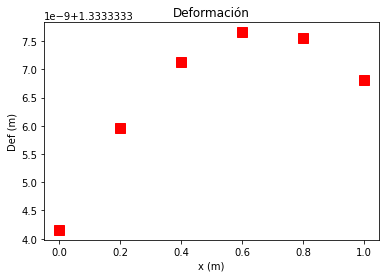

In [147]:
#Cálculo de la solución
psi = np.linalg.solve(AwithR, bwithr)
 #Graficamos
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,1)
axs.set_xlabel('x (m)')
axs.set_ylabel('Def (m)')
plt.title('Deformación')

#Printeamos la solución
print(np.reshape(psi, nx+1))

xu = np.linspace(0, 1.0, nx+1,endpoint = True)

axs.plot(xu,psi,'rs',markersize=10)



### 2. Compare la solución con el script en FEniCS

**Importo Fenics y defino la malla**

In [162]:
from fenics import *
# Defino la malla
nx = 5 #numero de intervalos
nodos = nx+1 #cantidad de nodos

l0 = 1.0 #Longitud de la viga en [m]

minx, maxx= 0.0, l0 
mesh = IntervalMesh(nx, minx, maxx)#Malla en 1D 

**Definimos el dominio donde se definen nuestras funciones aproximadas (u, v)**

In [163]:
V0 = FunctionSpace(mesh, 'CG',1)#Continuous Lagrange elements, funciones sombreros

**Definimos los bordes y los requisitos que debe cumplir el vértice para pertenecer a dicho borde**

In [171]:
class borde_izq(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and near(x[0], 0.0, tol)

class borde_der(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        l0 = 1.0
        return on_boundary and near(x[0], l0, tol)

**Explicitamos que sobre dichos bordes anteriormente definidos aplicaremos condiciones.
A su vez identificamos a los elementos de dichos bordes con un nombre. En este caso los
elementos pertenecientes al borde izquierdo serán los elementos 0, mientras que los del borde
derecho son los elementos 1:**

In [172]:
marcador_borde = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
bc_der = borde_der()
bc_izq = borde_izq()
bc_der.mark(marcador_borde, 1)
bc_izq.mark(marcador_borde, 0)
ds = Measure('ds', domain=mesh, subdomain_data=marcador_borde)

**Creamos las funciones con las cuales operaremos:**

In [173]:
u = TrialFunction(V0)
v = TestFunction(V0)
f = Constant(1.0)

**Realizamos un diccionario el cual almacenará las condiciones de borde con sus respectivas variables con la cual
se define:**

In [174]:
bound_cond = {0:{'Robin' : (k0, g0)},
              1:{'Robin' : (k1, g1)}}

**Armamos una lista con las expresiones obtenidas de las condiciones de borde de Robin para luego operar:**

In [175]:
bc_R = []
for i in bound_cond:
    if 'Robin' in bound_cond[i]:
        k, g = bound_cond[i]['Robin']
        bc_R.append(k*(u-g)*v*ds(i))

**Agrupamos todo el sistema de ecuaciones en un solo lado de la ecuación y utilizamos herramientas propias de Fenics
que nos extraerá la parte lineal L(v) y bilineal a(u,v):**

In [176]:
F = Ar*E*dot(grad(u), grad(v))*dx + sum(bc_R)-f*v*dx

a, L = lhs(F), rhs(F)

**Resolvemos y graficamos:**

Cantidad de celdas: 5
Cantidad de vertices: 6


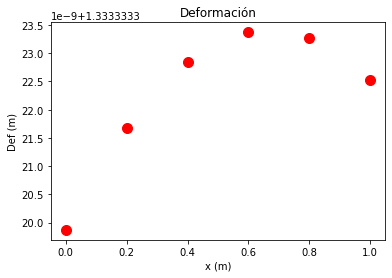

[1.33333332 1.33333332 1.33333332 1.33333332 1.33333332 1.33333332]


In [177]:
#Resolvemos 
u = Function(V0)
solve(a == L, u)

#Graficamos
import matplotlib.pyplot as plt
uh = u.compute_vertex_values(mesh) 
print('Cantidad de celdas:',nx)
print('Cantidad de vertices:',len(uh))
fig, axs = plt.subplots(1,1)

import numpy as np
xu = np.linspace(0.0, 1, len(uh),endpoint = True)
axs.plot(xu,uh,'ro',markersize=10)
axs.set_xlabel('x (m)')
axs.set_ylabel('Def (m)')
plt.title('Deformación')
plt.show()
print(uh)

**Printeamos los resultados obtenidos por las distintas vías y comparamos el error:**

In [179]:
print('Resultado a mano: ', np.reshape(psi,nx+1))
print('Resultado Fenics: ', uh)
uh-np.reshape(psi,nx+1)

Resultado a mano:  [1.3333333  1.33333331 1.33333331 1.33333331 1.33333331 1.33333331]
Resultado Fenics:  [1.33333332 1.33333332 1.33333332 1.33333332 1.33333332 1.33333332]


array([1.57150573e-08, 1.57150573e-08, 1.57150575e-08, 1.57150575e-08,
       1.57150577e-08, 1.57150579e-08])

**Podemos osbervar que los resultados obtenidos de una y otra manera son muy similares, existe una diferencia de
aproximadamente de 1.5E-8, la cuál es mínima pero existe. Estuve revisando y la verdad no sé que me podría faltar
en el script de Fenics para que la diferencia sea lo más mínima posible. Sin embargo, podemos observar que, al 
aumentar la constante elástica del resorte del borde izquierdo 'ko', la deformación es menor, lo cuál fisicamente 
es razonable ya que bajo una misma fuerza la deformación es menor.**